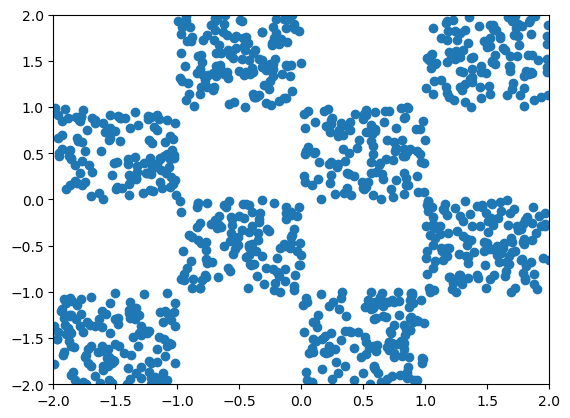

In [1]:
import numpy as np
import matplotlib.pyplot as plt


window_size = (4, 4)
NUM_POINTS = 1000
SIGMA = 0.4

# Creating the samples from the target distribution (a checkerboard pattern from window_size)
def sample_checkerboard(num_samples):
    # Generate more points than needed to ensure enough after filtering
    oversample = num_samples * 4
    points = np.random.uniform(
        low=[-window_size[0]/2, -window_size[1]/2],
        high=[window_size[0]/2, window_size[1]/2],
        size=(oversample, 2)
    )
    
    # Create checkerboard mask
    checker_size = 1.0  # Size of each checker square
    mask = ((points[:,0] // checker_size + points[:,1] // checker_size) % 2 == 0)
    
    # Keep only points that satisfy the mask
    valid_points = points[mask]
    
    # If we don't have enough points, generate more
    while len(valid_points) < num_samples:
        extra_points = np.random.uniform(
            low=[-window_size[0]/2, -window_size[1]/2],
            high=[window_size[0]/2, window_size[1]/2],
            size=(oversample, 2)
        )
        extra_mask = ((extra_points[:,0] // checker_size + extra_points[:,1] // checker_size) % 2 == 0)
        valid_points = np.vstack([valid_points, extra_points[extra_mask]])
    
    # Randomly select exactly num_samples points
    indices = np.random.choice(len(valid_points), num_samples, replace=False)
    return valid_points[indices]


target_data = sample_checkerboard(NUM_POINTS)

plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.scatter(target_data[:, 0], target_data[:, 1], alpha=1)
plt.show()


# Training code

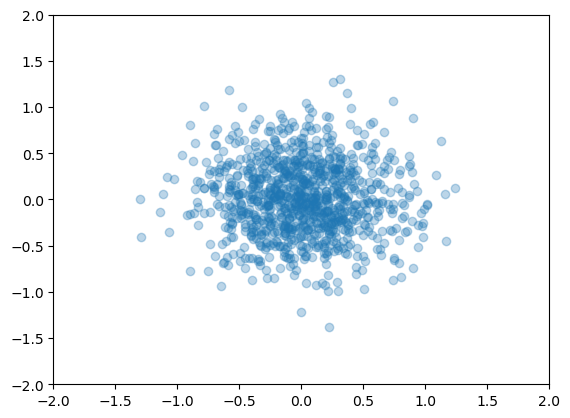

In [2]:



sample = np.random.randn(NUM_POINTS, 2) * SIGMA

np.random.seed(0)

# set radius of scatter plot point to 0.1

plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.3)
plt.show()

In [3]:
def noise_schedule(source, target, t):
    return source * t + target * (1 - t)

100%|██████████| 100000/100000 [25:10<00:00, 66.21it/s]  


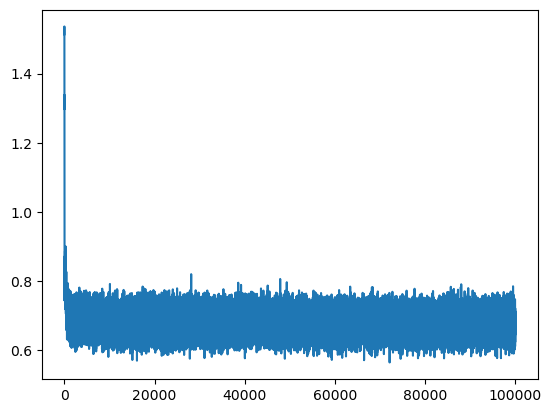

torch.Size([1000, 2])


In [4]:
import torch
from models import FlowMatchingModel
from tqdm import tqdm
NUM_ITERATIONS = 100_000

TimeSteps = 100

model = FlowMatchingModel(2, 512, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

losses = []

target_data = torch.from_numpy(target_data).float()



for i in tqdm(range(NUM_ITERATIONS)):
    
    # sample from the distributions
    source_data = torch.randn(NUM_POINTS, 2) * SIGMA
    
    
    optimal_transport_line = target_data - source_data
    
    # sample random timestep t  
    t = torch.rand(NUM_POINTS)
    
    input_data = noise_schedule(source_data, target_data, t.unsqueeze(1))
    
    
    # train the flow matching model
    predictions = model.forward(input_data, t)
    
    loss = torch.nn.functional.mse_loss(predictions, optimal_transport_line)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    

plt.plot(losses)
plt.show()
print(target_data.shape)
    

# Inference

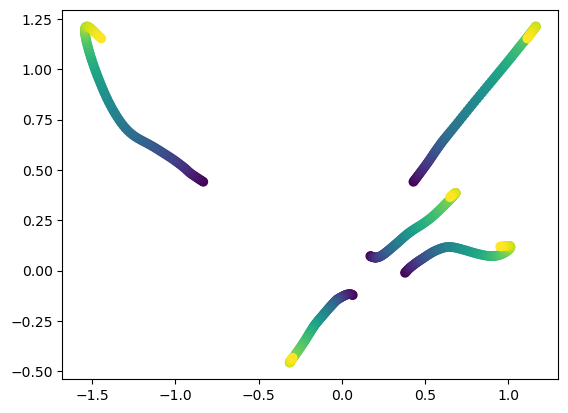

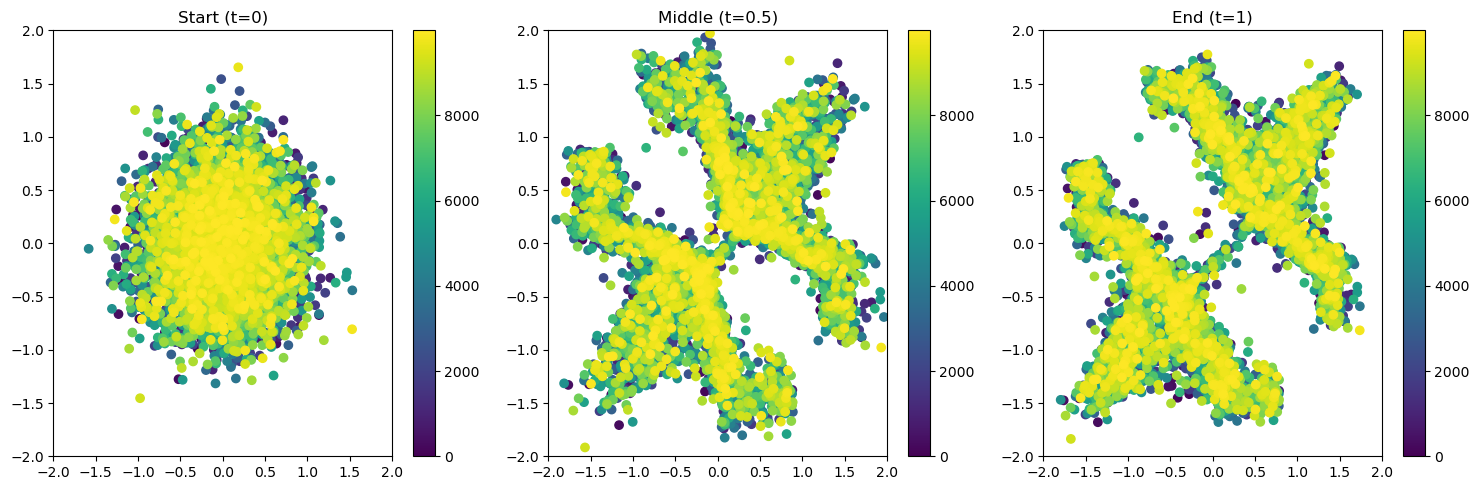

In [5]:
model.eval()

NUM_SAMPLE_POINTS = 10_000

source_data = torch.randn(NUM_SAMPLE_POINTS, 2) * SIGMA

coordinates = torch.zeros((TimeSteps + 1, NUM_SAMPLE_POINTS, 2))

coordinates[0, :, :] = source_data
with torch.no_grad():   
    for i in range(TimeSteps):
        # Current time t
        current_t = i / TimeSteps
        # Next time t + dt
        next_t = (i + 1) / TimeSteps
        # Time step size dt
        dt = 1 / TimeSteps
        
        # Get current point positions
        current_points = coordinates[i, :, :]
        
        # Get vector field at current positions and time
        vector_field = model.forward(current_points, torch.ones(NUM_SAMPLE_POINTS) * next_t)
        
        # Euler step integration: x_{t+dt} = x_t + v_t * dt
        next_points = current_points + vector_field * dt
        
        # Store the new positions
        coordinates[i + 1, :, :] = next_points

plt.scatter(coordinates[:,0,0], coordinates[:,0,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,1,0], coordinates[:,1,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,2,0], coordinates[:,3,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,3,0], coordinates[:,3,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,4,0], coordinates[:,4,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)

plt.show()


# Plot points at start, middle and end
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(coordinates[0,:,0], coordinates[0,:,1], c=range(NUM_SAMPLE_POINTS), cmap='viridis')
plt.title('Start (t=0)')
plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar()

plt.subplot(132)
plt.scatter(coordinates[TimeSteps//2,:,0], coordinates[TimeSteps//2,:,1], c=range(NUM_SAMPLE_POINTS), cmap='viridis')
plt.title('Middle (t=0.5)')
plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar()

plt.subplot(133)
plt.scatter(coordinates[-1,:,0], coordinates[-1,:,1], c=range(NUM_SAMPLE_POINTS), cmap='viridis')
plt.title('End (t=1)')
plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar()

plt.tight_layout()
plt.show()

# plot and save the movement of the points as a gif
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
scatter = ax.scatter([], [], c=[], cmap='viridis')
ax.set_xlim(-window_size[0]/2, window_size[0]/2)
ax.set_ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar(scatter)

def animate(frame):
    scatter.set_offsets(coordinates[frame])
    # scatter.set_array(range(NUM_SAMPLE_POINTS) / float(NUM_SAMPLE_POINTS))
    scatter.set_array(np.linspace(0, 1, NUM_SAMPLE_POINTS))
    return scatter,

anim = FuncAnimation(fig, animate, frames=TimeSteps+1, interval=50, blit=True)
anim.save('flow_matching.gif', writer='pillow')
plt.close()


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import os

def create_vector_field_animation(model, save_path='flow_matching_vector_field.gif', 
                                 window_size=(4, 4), resolution=20, time_steps=TimeSteps, 
                                 sample_points=1000, fps=10, dpi=100):
    """
    Creates and saves a GIF animation of the vector field over time from a flow matching model.
    
    Args:
        model: The trained flow matching model
        save_path: Path to save the GIF animation
        window_size: Tuple of (width, height) for plot window
        resolution: Number of grid points in each dimension for vector field visualization
        time_steps: Number of time steps to visualize
        sample_points: Number of sample points to track through time
        fps: Frames per second for the animation
        dpi: Resolution of the output GIF
    """
    model.eval()
    device = next(model.parameters()).device

    # Create a grid of points for vector field visualization
    x = np.linspace(-window_size[0]/2, window_size[0]/2, resolution)
    y = np.linspace(-window_size[1]/2, window_size[1]/2, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Sample initial points to track through time (Gaussian distribution)
    sigma = 0.5
    initial_points = torch.randn(sample_points, 2) * sigma
    
    # Store trajectory of points over time
    trajectories = torch.zeros((time_steps + 1, sample_points, 2))
    trajectories[0, :, :] = initial_points
    
    # Function to compute vector field at a specific time
    def compute_vector_field(t_value):
        """Computes vector field at grid points for time t_value"""
        grid_points = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))).float().to(device)
        time_tensor = torch.ones(grid_points.shape[0], device=device) * t_value
        
        with torch.no_grad():
            vectors = model(grid_points, time_tensor).cpu().numpy()
        
        # Reshape back to grid
        U = vectors[:, 0].reshape(resolution, resolution)
        V = vectors[:, 1].reshape(resolution, resolution)
        
        # Calculate vector magnitudes for coloring
        magnitudes = np.sqrt(U**2 + V**2)
        
        return U, V, magnitudes
    
    # Compute trajectories
    with torch.no_grad():
        for i in range(time_steps):
            current_t = i / time_steps
            dt = 1 / time_steps
            
            # Current points
            current_points = trajectories[i, :, :].to(device)
            time_tensor = torch.ones(sample_points, device=device) * current_t
            
            # Compute vector field at current points
            vector_field = model(current_points, time_tensor)
            
            # Euler integration
            next_points = current_points + vector_field * dt
            
            # Store
            trajectories[i + 1, :, :] = next_points.cpu()
    
    # Create the animation
    fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
    
    # Function for initialization
    def init():
        ax.clear()
        ax.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax.set_ylim(-window_size[1]/2, window_size[1]/2)
        return []
    
    # Animation function
    def animate(i):
        t_value = i / time_steps
        ax.clear()
        ax.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax.set_ylim(-window_size[1]/2, window_size[1]/2)
        ax.set_title(f'Vector Field at t = {t_value:.2f}')
        
        # Compute vector field
        U, V, magnitudes = compute_vector_field(t_value)
        
        # Create a normalized colormap based on vector magnitudes
        norm = Normalize(vmin=0, vmax=np.max(magnitudes)*1.2)
        
        # Plot vector field with quiver
        quiver = ax.quiver(X, Y, U, V, magnitudes, cmap='plasma', 
                          norm=norm, scale=20, width=0.003)
        
        # Plot trajectory points up to current time
        if i > 0:
            points = trajectories[i, :, :].numpy()
            # Color by vector magnitude
            point_vectors = model(
                torch.tensor(points, device=device),
                torch.ones(points.shape[0], device=device) * t_value
            ).detach().cpu().numpy()
            point_magnitudes = np.sqrt(point_vectors[:, 0]**2 + point_vectors[:, 1]**2)
            scatter = ax.scatter(points[:, 0], points[:, 1], 
                               c=point_magnitudes, cmap='plasma', 
                               norm=norm, s=10, alpha=0.7)
        
        # Add colorbar
        if i == 0:
            cbar = plt.colorbar(quiver, ax=ax)
            cbar.set_label('Vector Magnitude')
        
        return [quiver]
    
    # Create animation
    anim = FuncAnimation(
        fig, animate, init_func=init,
        frames=time_steps+1, interval=1000/fps, blit=False)
    
    # Save animation
    print(f"Saving animation to {save_path}...")
    anim.save(save_path, writer='pillow', fps=fps)
    plt.close(fig)
    print(f"Animation saved successfully!")
    
    # Create an additional plot showing the full trajectories
    plt.figure(figsize=(10, 10), dpi=dpi)
    plt.title("Full Trajectories")
    
    # Get final vector field for background
    U, V, magnitudes = compute_vector_field(1.0)
    
    # Plot vector field
    plt.quiver(X, Y, U, V, magnitudes, cmap='plasma', scale=20, width=0.003)
    
    # Plot full trajectories with gradual color change
    for i in range(sample_points):
        points = trajectories[:, i, :].numpy()
        # Color gradient from blue to red
        colors = plt.cm.viridis(np.linspace(0, 1, time_steps+1))
        for j in range(time_steps):
            plt.plot(points[j:j+2, 0], points[j:j+2, 1], color=colors[j], alpha=0.5)
    
    # Plot start and end points
    plt.scatter(trajectories[0, :, 0], trajectories[0, :, 1], 
               color='blue', s=30, label='Start (t=0)')
    plt.scatter(trajectories[-1, :, 0], trajectories[-1, :, 1], 
               color='red', s=30, label='End (t=1)')
    
    plt.legend()
    plt.xlim(-window_size[0]/2, window_size[0]/2)
    plt.ylim(-window_size[1]/2, window_size[1]/2)
    plt.savefig(os.path.splitext(save_path)[0] + '_trajectories.png')
    plt.close()
    
    return trajectories

# Example usage
def visualize_flow_model(model, sigma=0.5, window_size=(4, 4)):
    """
    Wrapper function to visualize a flow matching model.
    
    Args:
        model: The trained flow matching model
        sigma: Standard deviation for initial distribution
        window_size: Size of the visualization window
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Create directory for output if it doesn't exist
    os.makedirs('flow_visualizations', exist_ok=True)
    
    # Generate and save vector field animation
    trajectories = create_vector_field_animation(
        model=model,
        save_path='flow_visualizations/vector_field_animation.gif',
        window_size=window_size,
        resolution=20,  # Grid resolution for vector field
        time_steps=40,  # Number of time steps to visualize
        sample_points=200,  # Number of sample points to track
        fps=10,
        dpi=100
    )
    
    # Generate additional visualization showing evolution of density
    time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
    fig, axes = plt.subplots(1, len(time_snapshots), figsize=(15, 4), dpi=100)
    
    for i, t in enumerate(time_snapshots):
        t_idx = int(t * 40)  # Assuming 40 time steps as above
        if t_idx >= len(trajectories):
            t_idx = len(trajectories) - 1
            
        points = trajectories[t_idx].numpy()
        axes[i].scatter(points[:, 0], points[:, 1], s=5, alpha=0.5, c='blue')
        axes[i].set_title(f't = {t:.2f}')
        axes[i].set_xlim(-window_size[0]/2, window_size[0]/2)
        axes[i].set_ylim(-window_size[1]/2, window_size[1]/2)
        axes[i].set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('flow_visualizations/density_evolution.png')
    plt.close()
    
    print("All visualizations completed successfully!")
    
    return trajectories

visualize_flow_model(model)


Saving animation to flow_visualizations/vector_field_animation.gif...
Animation saved successfully!
All visualizations completed successfully!


tensor([[[ 1.1672, -0.1968],
         [ 0.3153,  0.0315],
         [ 0.3884,  0.5346],
         ...,
         [-0.6533, -0.0174],
         [-1.0629, -0.4978],
         [-0.1257, -0.1570]],

        [[ 1.1981, -0.1996],
         [ 0.3237,  0.0324],
         [ 0.3989,  0.5483],
         ...,
         [-0.6681, -0.0239],
         [-1.0708, -0.5111],
         [-0.1258, -0.1616]],

        [[ 1.2305, -0.2030],
         [ 0.3328,  0.0343],
         [ 0.4095,  0.5630],
         ...,
         [-0.6838, -0.0307],
         [-1.0727, -0.5247],
         [-0.1252, -0.1654]],

        ...,

        [[ 1.6936, -0.3601],
         [ 0.9054,  0.2964],
         [ 1.1472,  1.2882],
         ...,
         [-1.3654,  0.1818],
         [-1.5917, -1.3146],
         [-0.4681, -0.5373]],

        [[ 1.6650, -0.3471],
         [ 0.8926,  0.2922],
         [ 1.1347,  1.2721],
         ...,
         [-1.3477,  0.1734],
         [-1.5726, -1.3088],
         [-0.4616, -0.5312]],

        [[ 1.6320, -0.3347],
       